# Analysis of Green Space Visibility in Urban Areas Using Street View Imagery with Mask2Former Segmentation

## Install Dependencies

In [ ]:
!pip install transformers torch torchvision torchaudio
!pip install pillow matplotlib numpy scipy tqdm
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

##  Import Libraries

In [ ]:
import torch
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from PIL import Image, ImageFile
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import cv2

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Load Mask2Former Model

In [ ]:
def get_models():
    """Load pretrained Mask2Former model"""
    # [1](#0-0)
    processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")
    # [2](#0-1)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")
    # [3](#0-2)
    model = model.to(device)
    return processor, model

In [ ]:
# Load models
processor, model = get_models()
print("Model loaded successfully!")
print(f"Using device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `Mask2FormerImageP

Model loaded successfully!
Using device: cuda


## Segmentation Function

In [ ]:
def segment_images(image, processor, model):
    """Perform semantic segmentation on image"""
    # [4](#0-3)
    inputs = processor(images=image, return_tensors="pt")

    # [5](#0-4)
    with torch.no_grad():
        if torch.cuda.is_available():
            inputs = {k: v.to('cuda') for k, v in inputs.items()}
            outputs = model(**inputs)
            segmentation = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0].to('cpu')
        else:
            outputs = model(**inputs)
            segmentation = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

    return segmentation

## Color Palette for Visualization

In [ ]:
# [6](#0-5)
color_palette = [
    [128, 64, 128],  # 0: road - maroon
    [244, 35, 232],  # 1: sidewalk - pink
    [70, 70, 70],    # 2: building - dark gray
    [102, 102, 156], # 3: wall - purple
    [190, 153, 153], # 4: fence - light brown
    [153, 153, 153], # 5: pole - gray
    [250, 170, 30],  # 6: traffic light - orange
    [220, 220, 0],   # 7: traffic sign - yellow
    [0, 255, 0],     # 8: vegetation - dark green
    [152, 251, 152], # 9: terrain - light green
    [70, 130, 180],  # 10: sky - blue
    [220, 20, 60],   # 11: person - red
    [255, 0, 0],     # 12: rider - bright red
    [0, 0, 142],     # 13: car - dark blue
    [0, 0, 70],      # 14: truck - navy blue
    [0, 60, 100],    # 15: bus - dark teal
    [0, 80, 100],    # 16: train - dark green
    [0, 0, 230],     # 17: motorcycle - blue
    [119, 11, 32]    # 18: bicycle - dark red
]

## Green View Index (GVI) Calculation

In [ ]:
def get_GVI(segmentation):
    """Calculate Green View Index from segmentation"""
    # [7](#0-6)
    total_pixels = segmentation.numel()
    vegetation_pixels = (segmentation == 8).sum().item()
    return vegetation_pixels / total_pixels if total_pixels else 0

## Visualization Function

In [ ]:
def visualize_results(image, segmentation, gvi, title_prefix=""):
    """Visualize original image and segmentation result"""
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Display original image
    ax1.imshow(image)
    # Extract only the filename from the title_prefix for a cleaner title
    clean_title = os.path.basename(title_prefix)
    ax1.set_title(f"{clean_title} - Original Image")
    ax1.axis("off")

    # [8](#0-7)
    seg_color = np.zeros(segmentation.shape + (3,), dtype=np.uint8)
    for label, color in enumerate(color_palette):
        seg_color[segmentation == label] = color

    # Display segmentation
    ax2.imshow(seg_color)
    ax2.set_title(f"{clean_title} - Segmentation (GVI: {gvi:.4f})")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

## Upload Images Function

In [ ]:
from google.colab import files
import io

def upload_images():
    """Upload images to Google Colab"""
    print("Silakan upload gambar-gambar Anda:")
    uploaded = files.upload()

    image_files = []
    for filename in uploaded.keys():
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(filename)

    return image_files

## Process Multiple Images

In [ ]:
def process_multiple_images(image_files, directions=['depan', 'kiri', 'kanan']):
    """Process multiple images and calculate GVI for each direction"""
    results = []

    # Group images by location (assuming naming convention: location_direction.jpg)
    locations = {}
    for file in image_files:
        # Extract location from filename (customize based on your naming convention)
        parts = file.split('_')
        if len(parts) >= 2:
            location = parts[0]
            direction = parts[1].split('.')[0]

            if location not in locations:
                locations[location] = {}
            locations[location][direction] = file

    print(f"Found {len(locations)} locations with images")

    for location, direction_files in locations.items():
        print(f"\nProcessing location: {location}")
        location_gvi = []

        for direction in directions:
            if direction in direction_files:
                filename = direction_files[direction]
                print(f"  Processing {direction}: {filename}")

                # Load and process image
                image = Image.open(filename)

                segmentation = segment_images(image, processor, model)
                gvi = get_GVI(segmentation)

                # Visualize results
                visualize_results(image, segmentation, gvi, f"{location} - {direction}")

                location_gvi.append(gvi)
                print(f"    GVI for {direction}: {gvi:.4f}")
            else:
                print(f"  Missing image for direction: {direction}")
                location_gvi.append(0)

        # Calculate average GVI for location
        avg_gvi = sum(location_gvi) / len(location_gvi) if location_gvi else 0
        results.append({
            'location': location,
            'gvi_depan': location_gvi[0] if len(location_gvi) > 0 else 0,
            'gvi_kiri': location_gvi[1] if len(location_gvi) > 1 else 0,
            'gvi_kanan': location_gvi[2] if len(location_gvi) > 2 else 0,
            'gvi_average': avg_gvi
        })

        print(f"  Average GVI for {location}: {avg_gvi:.4f}")

    return results

## Simple Single Image Processing

In [ ]:
def process_single_image(image_path):
    """Process a single image"""
    image = Image.open(image_path)
    segmentation = segment_images(image, processor, model)
    gvi = get_GVI(segmentation)

    visualize_results(image, segmentation, gvi, os.path.basename(image_path))

    return gvi

## Main Execution

In [ ]:
# Option 1: Upload and process multiple images
print("=== UPLOAD DAN PROSES GAMBAR ===")
image_files = upload_images()

if image_files:
    print(f"\nGambar yang ter-upload: {len(image_files)} files")
    for file in image_files:
        print(f"  - {file}")

    # Process all images
    results = process_multiple_images(image_files)

    # Display summary results
    print("\n=== RINGKASAN HASIL GVI ===")
    print("Location\t\tDepan\t\tKiri\t\tKanan\t\tRata-rata")
    print("-" * 70)
    for result in results:
        print(f"{result['location']}\t\t{result['gvi_depan']:.4f}\t\t{result['gvi_kiri']:.4f}\t\t{result['gvi_kanan']:.4f}\t\t{result['gvi_average']:.4f}")

## Export Results

In [ ]:
import pandas as pd

def export_results_to_csv(results, filename="gvi_results.csv"):
    """Export results to CSV file"""
    df = pd.DataFrame(results)
    df.to_csv(filename, index=False)

    print(f"Results exported to {filename}")
    files.download(filename)

# Export results if available
if 'results' in locals() and results:
    export_results_to_csv(results)

## Alternative - Process Single Image

In [ ]:
# If you want to process just one image at a time, use this:
"""
# Upload single image
from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"Processing: {filename}")
    gvi = process_single_image(filename)
    print(f"GVI: {gvi:.4f}")
"""

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Process Images from Google Drive

In [ ]:
import os

image_folder_path = '/content/drive/MyDrive/Green Space Visibility/DataSets'

if not os.path.exists(image_folder_path):
    print(f"Error: Folder '{image_folder_path}' not found.")
else:
    print(f"Reading images from: {image_folder_path}")
    # Get list of image files in the specified folder
    all_files = os.listdir(image_folder_path)
    drive_image_files = [os.path.join(image_folder_path, f) for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not drive_image_files:
        print("No image files found in the specified folder.")
    else:
        print(f"\nFound {len(drive_image_files)} image files in Google Drive.")
        for file in drive_image_files:
            print(f"  - {file}")

        # Process all images from Google Drive
        # Note: The process_multiple_images function assumes a naming convention (location_direction.jpg)
        # Make sure your filenames in Google Drive follow this convention or adjust the function accordingly.
        results_drive = process_multiple_images(drive_image_files)

        # Display summary results
        print("\n=== RINGKASAN HASIL GVI DARI GOOGLE DRIVE ===")
        print("Location\t\tDepan\t\tKiri\t\tKanan\t\tRata-rata")
        print("-" * 70)
        for result in results_drive:
             print(f"{result['location']}\n{result['gvi_depan']:.4f}\t\t{result['gvi_kiri']:.4f}\t\t{result['gvi_kanan']:.4f}\t\t{result['gvi_average']:.4f}")

        # Export results to CSV
        export_results_to_csv(results_drive, filename="gvi_results_drive.csv")

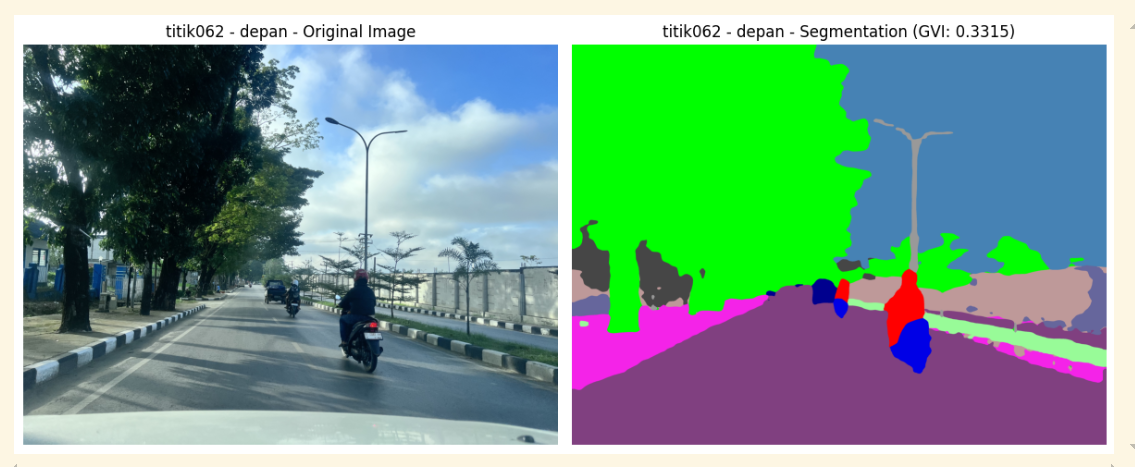

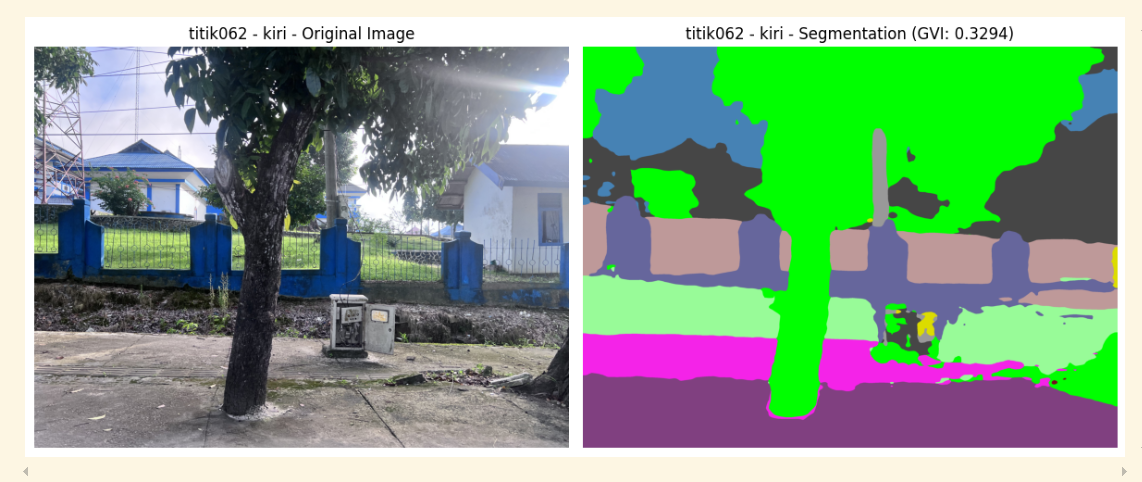

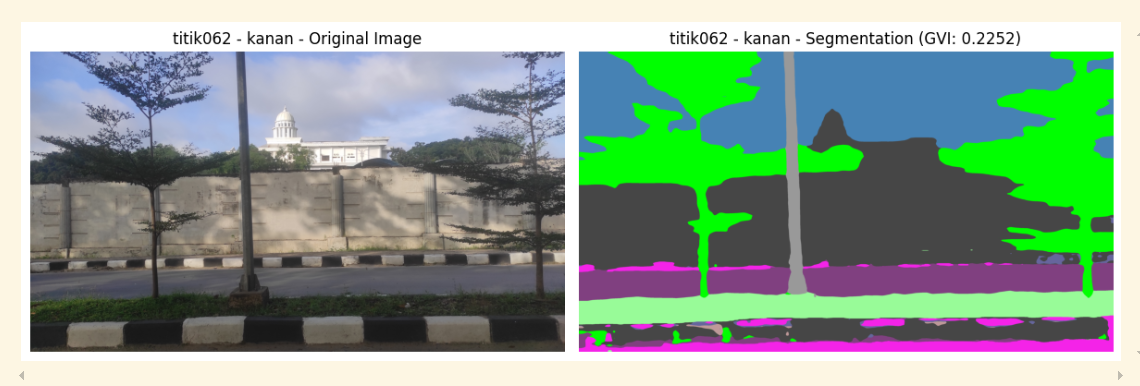